In [1]:
import sys 
sys.path.append("../")

import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sb

from training import RunningAverage
from testing import * 
from data.dataprep import DataPrep
from data.utils import sliding_window, win_to_seq
from torch_dvae.measurement_models import * 
from torch_dvae.transition_models import * 
from torch_dvae.encoder_models import * 
from torch_dvae.inference_models import * 
from torch_dvae.initializers import * 
from torch_dvae.DVAE import DVAE 

%matplotlib inline 

In [2]:
sb.set_theme()

# Data Prep for Semi-Supervised Training/Testing

In [3]:
PATH = "..\\CMAPSS"
dataset = "FD001"
stride = 1 
T = 40 
split = 0.2 
bs = 250 

prep_class = DataPrep(PATH, dataset)

if dataset == "FD001" or dataset == "FD003":
    prep_class.op_normalize(K=1)    # K=1 normalization, K=6 operating condition norm 
else: 
    prep_class.op_normalize(K=6) 

x_train, y_train, t_train = prep_class.prep_data(prep_class.ntrain, T, stride)
x_test, y_test, t_test = prep_class.prep_test(prep_class.ntest, prep_class.RUL)

In [4]:
class SemiDataset(Dataset):
    def __init__(self, x_data, y_data, ulb_idxs):
        self.x_data = x_data 
        self.y_data = y_data 
        self.ulb_idxs = ulb_idxs 

    def __len__(self):
        return self.x_data.size(0)
    
    def __getitem__(self, index):
        """
        Replaces unlabelled data targets with -1's which the semi-supervised training class 
        will ignore when calculating the supervised loss. 
        """
        x = self.x_data[index]
        if index in self.ulb_idxs:
            y = -1 * torch.ones(self.y_data[index].shape)   # replace with -1's
        else: 
            y = self.y_data[index]

        return x, y 

In [5]:
percentage_unlabelled = 0.
split = percentage_unlabelled / 100.

rng = np.random.default_rng()
ulb_idxs = rng.choice(x_train.shape[0], size=int(x_train.shape[0] * split), replace=False)

In [6]:
ulb_idxs.shape

(0,)

In [7]:
semi_ds = SemiDataset(x_train, y_train, ulb_idxs)

In [8]:
def extract_input_target_pairs(xs, ys):
    y_shape = (-1,) + tuple(ys.shape[1:])
    x_shape = (-1,) + tuple(xs.shape[1:])

    mask = (ys != -1)[:,:,0]
    lb_ys = ys[mask].reshape(y_shape)
    lb_xs = xs[mask].reshape(x_shape)
    return lb_xs, lb_ys 

In [9]:
bs = 250

train_loader = DataLoader(semi_ds, bs)

# recreate new dataset with only a certain % of labels 
xs = torch.tensor([])
ys = torch.tensor([])
for x, y in train_loader:
    xs = torch.cat((x, xs), dim=0)
    ys = torch.cat((y, ys), dim=0)

valid_split = 0.2
un_xs, un_ys, _, x_valid, y_valid, _ = prep_class.valid_set(xs, ys, torch.randn(xs.shape), split=valid_split)

valid_ds = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_ds, bs)

train_ds = TensorDataset(un_xs, un_ys)
train_loader = DataLoader(train_ds, bs, shuffle=True)

In [10]:
list(train_loader)[0][0].shape

torch.Size([250, 40, 14])

# Create Training Functions 

In [19]:
class SemiSupervisedTrainer:
    def __init__(self, lr, L2):
        self.lr = lr 
        self.L2 = L2 

    def unsupervised_forward(self, model: DVAE, xs):
        # --- Inference --- 
        zs_inf_dists, y_1t, x_1t, y_1T, x_1T = model.inference_func(xs, xs)
        zs = zs_inf_dists.sample()  # type: ignore

        # --- Transition func --- 
        z0_dist = model.init_net(xs, xs)
        z0 = z0_dist.sample()
        zs_pri_dists = model.get_priors(z0, zs, y_1t, x_1T)

        # --- Measure func --- 
        x_dists = model.measure.get_dist(zs, y_1t, x_1T)
        
        # --- Losses --- 
        nll = -x_dists.log_prob(xs).sum(1).mean()   # type: ignore
        kl =  dists.kl.kl_divergence(zs_inf_dists, zs_pri_dists).sum(1).mean()
        return nll, kl, x_dists, zs_inf_dists

    def train_step(self, unsupervised_model: DVAE, model: DVAE, xs, ys, optimizer):
        # --- unsupervised stage --- 
        nll, kl, xs_dists, zs_dists = self.unsupervised_forward(unsupervised_model, xs)
        unsupervised_loss = nll + kl 

        # --- process data for supervised stage --- 
        zs = zs_dists.sample()       # type:ignore 
        xs_rec = xs_dists.sample()   # type:ignore  
        
        xs = torch.cat([xs_rec, zs], dim=-1)

        # --- supervised stage --- 
        lb_xs, lb_ys = extract_input_target_pairs(xs, ys)
        nll, kl = model.get_loss(lb_xs, lb_ys)
        supervised_loss = nll + kl 
        
        loss = unsupervised_loss + supervised_loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return unsupervised_loss, supervised_loss
    
    def valid_step(self, unsupervised_model: DVAE, model: DVAE, xs, ys):
        # --- unsupervised stage --- 
        nll, kl, xs_dists, zs_dists = self.unsupervised_forward(unsupervised_model, xs)
        unsupervised_loss = nll + kl 

        # --- process data for supervised stage --- 
        zs = zs_dists.sample()       # type:ignore 
        xs_rec = xs_dists.sample()   # type:ignore  
        
        xs = torch.cat([xs_rec, zs], dim=-1)

        # --- supervised stage --- 
        lb_xs, lb_ys = extract_input_target_pairs(xs, ys)
        nll, kl = model.get_loss(lb_xs, lb_ys)
        supervised_loss = nll + kl 
        
        loss = unsupervised_loss + supervised_loss

        return loss
    
    def train_model(self, epochs, train_loader, valid_loader, semi_supervised_model, 
                    model_PATH, device):
        best_loss = 1e10
        logger = RunningAverage()
        logger.add_key(["unsupervised loss", "supervised loss", "valid loss"])
        optimizer = torch.optim.Adam(semi_supervised_model.parameters(), self.lr, weight_decay=self.L2)

        unsupervised_model = semi_supervised_model.unsupervised_model
        model = semi_supervised_model.model

        for epoch in range(1, epochs+1):
            logger.reset_all()  # reset average counter and losses to zero 

            # --- Training --- 
            for xs, ys in train_loader:
                xs = xs.to(device).float()
                ys = ys.to(device).float()

                unsuper_loss, super_loss = self.train_step(unsupervised_model, model, xs, ys, optimizer)
                logger.add_loss(super_loss, "supervised loss")
                logger.add_loss(unsuper_loss, "unsupervised loss")

            # --- Validation --- 
            if epoch == 1 or epoch % 10 == 0 or epoch == epochs:
                with torch.no_grad():
                    for xs, ys in valid_loader:
                        xs = xs.to(device).float()
                        ys = ys.to(device).float()

                        valid_loss = self.valid_step(unsupervised_model, model, xs, ys)
                        logger.add_loss(valid_loss, "valid loss")

                    # average losses 
                    logger.avg_loss()   

                    # store losses 
                    super_loss = logger.get_avg_loss("supervised loss")
                    unsuper_loss = logger.get_avg_loss("unsupervised loss")
                    valid_loss = logger.get_avg_loss("valid loss")

                    if valid_loss < best_loss:
                        best_loss = valid_loss 
                        torch.save(semi_supervised_model.state_dict(), model_PATH)
                        message = "new best loss, saving model ..."
                    else:
                        message = ""

                    print(("Epoch {}/{}, unsupervised loss: {:.4f}, supervised loss: {:.4f}, valid loss: {:.4f} " + message)
                    .format(epoch, epochs, unsuper_loss, super_loss, valid_loss)) 

        semi_supervised_model.load_state_dict(torch.load(model_PATH))   # load the best performing model 
        return semi_supervised_model

class SemiSupervisedModel(nn.Module):
    def __init__(self, unsupervised_model, model):
        super().__init__()
        self.unsupervised_model = unsupervised_model
        self.model = model 

# Setup Model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
un_model_PATH = "saved_models/unDVAE"

xdim = x_train.shape[-1]
ydim = 1 
hdim = 50 
zdim = 2 

ruls_encoder = RNNEncoder(ydim, hdim)
sens_encoder = RNNEncoder(xdim, hdim)
un_init_net = MeasureInitializer(hdim, zdim, xdim, 0)
un_transition_net = MLPTransition(zdim, hdim, hdim, 0)
un_measure_net = MLPMeasure(xdim, zdim, hdim, hdim, 0)
un_inference_net = RNNInference(zdim, hdim, hdim, 0)

In [21]:
unsupervised_model = DVAE(un_inference_net, un_transition_net, un_measure_net, sens_encoder, EmptyEncoder(), un_init_net).to(device)

In [22]:
unsupervised_model

DVAE(
  (transition): MLPTransition(
    (net): GaussianNet(
      (net): MLP(
        (linear1): Linear(in_features=52, out_features=50, bias=True)
        (linear2): Linear(in_features=50, out_features=50, bias=True)
        (linear3): Linear(in_features=50, out_features=4, bias=True)
      )
    )
  )
  (measure): MLPMeasure(
    (net): GaussianNet(
      (net): MLP(
        (linear1): Linear(in_features=52, out_features=50, bias=True)
        (linear2): Linear(in_features=50, out_features=50, bias=True)
        (linear3): Linear(in_features=50, out_features=28, bias=True)
      )
    )
  )
  (x_encoder): EmptyEncoder()
  (y_encoder): RNNEncoder(
    (rnn_fwd): GRU(14, 50, batch_first=True)
    (rnn_bwd): GRU(64, 50, batch_first=True)
  )
  (inference): RNNInference(
    (inf_net): GaussianRNN(
      (rnn): GRU(50, 50, batch_first=True)
      (net): GaussianNet(
        (net): MLP(
          (linear1): Linear(in_features=50, out_features=50, bias=True)
          (linear2): Linear(in

In [23]:
inp_encoder = RNNEncoder(xdim+zdim, hdim)
init_net = ControlInitializer(hdim, zdim, ydim, xdim+zdim)
transition_net = MLPTransition(zdim, hdim, 0, hdim)
measure_net = MLPMeasure(ydim, zdim, hdim, 0, hdim)
inference_net = RNNInference(zdim, hdim, hdim, hdim)

In [24]:
model = DVAE(inference_net, transition_net, measure_net, ruls_encoder, inp_encoder, init_net).to(device)

model_PATH = "saved_models/semiDVAE"

In [25]:
model

DVAE(
  (transition): MLPTransition(
    (net): GaussianNet(
      (net): MLP(
        (linear1): Linear(in_features=52, out_features=50, bias=True)
        (linear2): Linear(in_features=50, out_features=50, bias=True)
        (linear3): Linear(in_features=50, out_features=4, bias=True)
      )
    )
  )
  (measure): MLPMeasure(
    (net): GaussianNet(
      (net): MLP(
        (linear1): Linear(in_features=52, out_features=50, bias=True)
        (linear2): Linear(in_features=50, out_features=50, bias=True)
        (linear3): Linear(in_features=50, out_features=2, bias=True)
      )
    )
  )
  (x_encoder): RNNEncoder(
    (rnn_fwd): GRU(16, 50, batch_first=True)
    (rnn_bwd): GRU(66, 50, batch_first=True)
  )
  (y_encoder): RNNEncoder(
    (rnn_fwd): GRU(1, 50, batch_first=True)
    (rnn_bwd): GRU(51, 50, batch_first=True)
  )
  (inference): RNNInference(
    (inf_net): GaussianRNN(
      (rnn): GRU(100, 50, batch_first=True)
      (net): GaussianNet(
        (net): MLP(
          (l

# Training/Testing Semi-Supervised model

In [26]:
trainer = SemiSupervisedTrainer(lr=1e-3, L2=1e-5)
semi_supervised_model = SemiSupervisedModel(unsupervised_model, model)

In [27]:
epochs = 200
semi_supervised_model = trainer.train_model(epochs, train_loader, valid_loader, semi_supervised_model, model_PATH, device)

Epoch 1/200, unsupervised loss: 38.3988, supervised loss: 37915.5203, valid loss: 992.2015 new best loss, saving model ...
Epoch 10/200, unsupervised loss: 24.1625, supervised loss: 246.8688, valid loss: 270.1964 new best loss, saving model ...
Epoch 20/200, unsupervised loss: 24.0259, supervised loss: 239.5506, valid loss: 263.6413 new best loss, saving model ...
Epoch 30/200, unsupervised loss: 23.9636, supervised loss: 237.8320, valid loss: 262.0161 new best loss, saving model ...
Epoch 40/200, unsupervised loss: 23.9318, supervised loss: 236.4200, valid loss: 260.5726 new best loss, saving model ...
Epoch 50/200, unsupervised loss: 23.9041, supervised loss: 234.8420, valid loss: 258.9050 new best loss, saving model ...
Epoch 60/200, unsupervised loss: 23.8773, supervised loss: 232.9548, valid loss: 256.9549 new best loss, saving model ...
Epoch 70/200, unsupervised loss: 23.8615, supervised loss: 230.5093, valid loss: 254.5448 new best loss, saving model ...
Epoch 80/200, unsupervi

In [49]:
def test_semisupervised_model(semi_supervised_model, test_x, test_y, test_t, T, N, device):
    results = {
        "y_true": [],
        "RMSE": 0, 
        "y_nll": 0, 
        "score": 0, 
        "y_mean": [],
        "y_stds": [], 
        "z_mean": [],
        "z_stds": [],
        "zs": [],
        "ys": [],
        "x_true": [],
        "x_mean": [],
        "x_stds": [], 
        "times": [] 
    }
    model = semi_supervised_model.model
    unsupervised_model = semi_supervised_model.unsupervised_model
    with torch.no_grad():
        MSE = [] 
        NLL = [] 
        scores = [] 
        T = int(T)
        for i, x in enumerate(test_x):
            y = test_y[i][0,:,:].to(device).float()
            x = x[0,:,:].to(device).float()
            t = test_t[i][0,:,0].to(device).float()

            # --- get time windowed data --- 
            x = sliding_window(x, T)
            y = sliding_window(y, T)

            # --- generate inputs and latent variables ---
            z_dist, x_dist = unsupervised_model.reconstruct(x, x)
            zs = z_dist.sample()         # type:ignore
            xs = x_dist.loc
            x_mean = x_dist.loc     # type:ignore
            x_stds = x_dist.scale   # type:ignore

            x_new = torch.cat([x, zs], dim=-1) # reconstructed sensors and latent 

            _, _, zs, ys = model.noncausal_forward(x_new, N)

            #z_dist = dists.normal.Normal(zs.mean(0), zs.std(0))
            y_dist = dists.normal.Normal(ys.mean(0), ys.std(0))

            z_mean = z_dist.loc     # type:ignore
            z_stds = z_dist.scale   # type:ignore
            y_mean = y_dist.loc     # type:ignore
            y_stds = y_dist.scale   # type:ignore

            # --- convert back to seq ---
            x = win_to_seq(x)
            x_mean = win_to_seq(x_mean)
            x_stds = win_to_seq(x_stds)
            y = win_to_seq(y)
            z_mean = win_to_seq(z_mean)
            z_stds = win_to_seq(z_stds)
            y_mean = win_to_seq(y_mean)
            y_stds = win_to_seq(y_stds)
            zs = win_to_seq(zs)
            ys = win_to_seq(ys)

            y_dist = dists.normal.Normal(y_mean, y_stds)
            # --- get losses --- 
            nll = -y_dist.log_prob(y).sum(0).mean()
            mse = (y_mean - y) ** 2

            # --- store variables --- 
            MSE.append(mse.detach().cpu().numpy())
            NLL.append(nll.detach().cpu().numpy())
            results["y_true"].append(y.detach().cpu().numpy())
            results["y_mean"].append(y_mean.detach().cpu().numpy())
            results["y_stds"].append(y_stds.detach().cpu().numpy())
            results["z_mean"].append(z_mean.detach().cpu().numpy())
            results["z_stds"].append(z_stds.detach().cpu().numpy())
            results["zs"].append(zs.detach().cpu().numpy())
            results["ys"].append(ys.detach().cpu().numpy())
            results["x_true"].append(x.detach().cpu().numpy())
            results["x_mean"].append(x_mean.detach().cpu().numpy())
            results["x_stds"].append(x_stds.detach().cpu().numpy())
            results["times"].append(t.detach().cpu().numpy())

    MSE = np.concatenate(MSE, axis=0)
    RMSE = np.sqrt(MSE.mean())
    results["RMSE"] = RMSE 

    nll = sum(NLL) / len(NLL)   # mean nll over all units 
    results["y_nll"] = nll 

    return results 


In [50]:
N = 100 
semi_supervised_model.load_state_dict(torch.load(model_PATH))
results = test_semisupervised_model(semi_supervised_model, x_test, y_test, t_test, T, N, device)

In [51]:
results["RMSE"]

8.930309

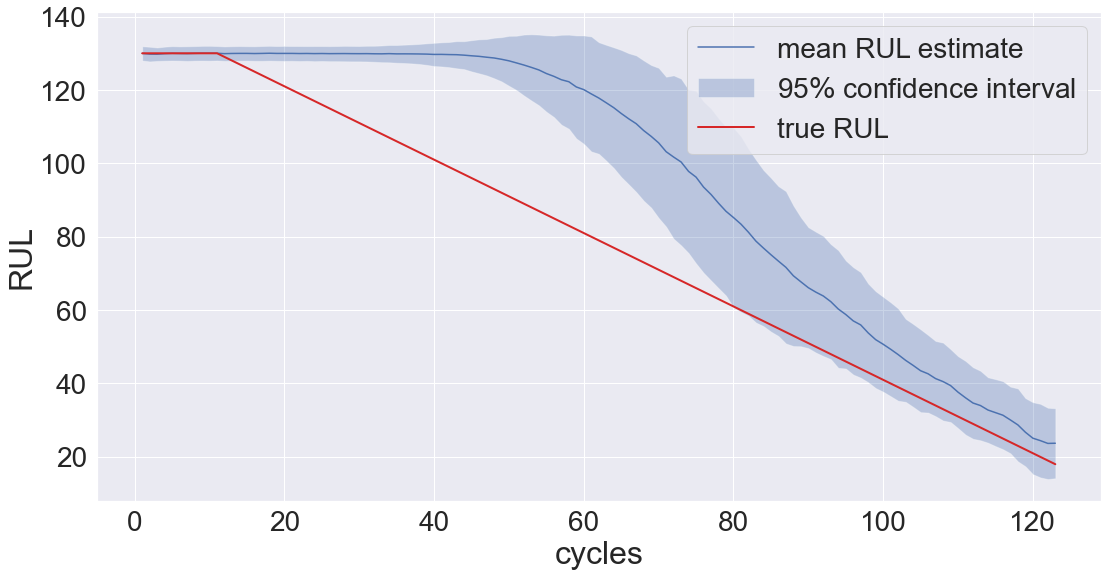

In [52]:
plot_rul_vs_time(41, results)

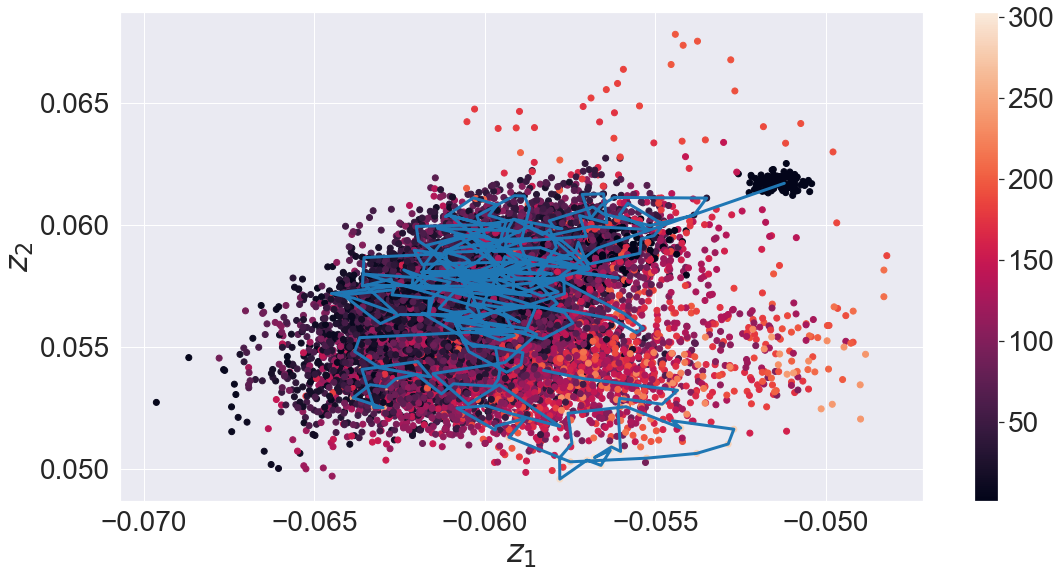

In [53]:
plot_latent_phase_space_all(results, 0, 1)

In [54]:
def plot_semi_supervised_sensors(unit, results):
    """
    Used for high dimensional DVAE inputs usually for sensor reconstruction plots 
    when using unsupervised training 
    """ 
    true = results["x_true"][unit-1]                  
    ests = results["x_mean"][unit-1] 
    stds = results["x_stds"][unit-1]  
    upper = ests + 3*stds 
    lower = ests - 3*stds

    seq = true.shape[1]
    t = results["times"][unit-1]
    ests = ests[:,:seq]
    upper = upper[:,:seq]
    lower = lower[:,:seq]

    sensors = true.shape[-1]
    dim = int(np.ceil(np.sqrt(sensors)))
    fig, axes = plt.subplots(dim, dim, figsize=(22,22))
    i = 0
    j = 0

    for sensor in range(sensors):
        if i == dim:
            i = 0 
            j += 1

        axes[i,j].plot(t, true[:,sensor], color="tab:red", label="True")                      # type:ignore
        axes[i,j].plot(t, ests[:,sensor], color="tab:blue", label="Estimates") # type:ignore
        axes[i,j].plot(t, upper[:,sensor], ls='--', color='k')        # type:ignore
        axes[i,j].plot(t, lower[:,sensor], ls='--', color='k')        # type:ignore
        axes[i,j].fill_between(t, upper[:,sensor], lower[:,sensor], color='k', alpha=0.2) # type:ignore
        axes[i,j].set_xlabel("cycles")                                  # type:ignore
        axes[i,j].set_ylabel("normalized sensor values")                # type:ignore
        axes[i,j].legend()                                              # type:ignore
        axes[i,j].set_title("sensor {}".format(sensor+1))               # type:ignore

        i += 1 
    plt.show()

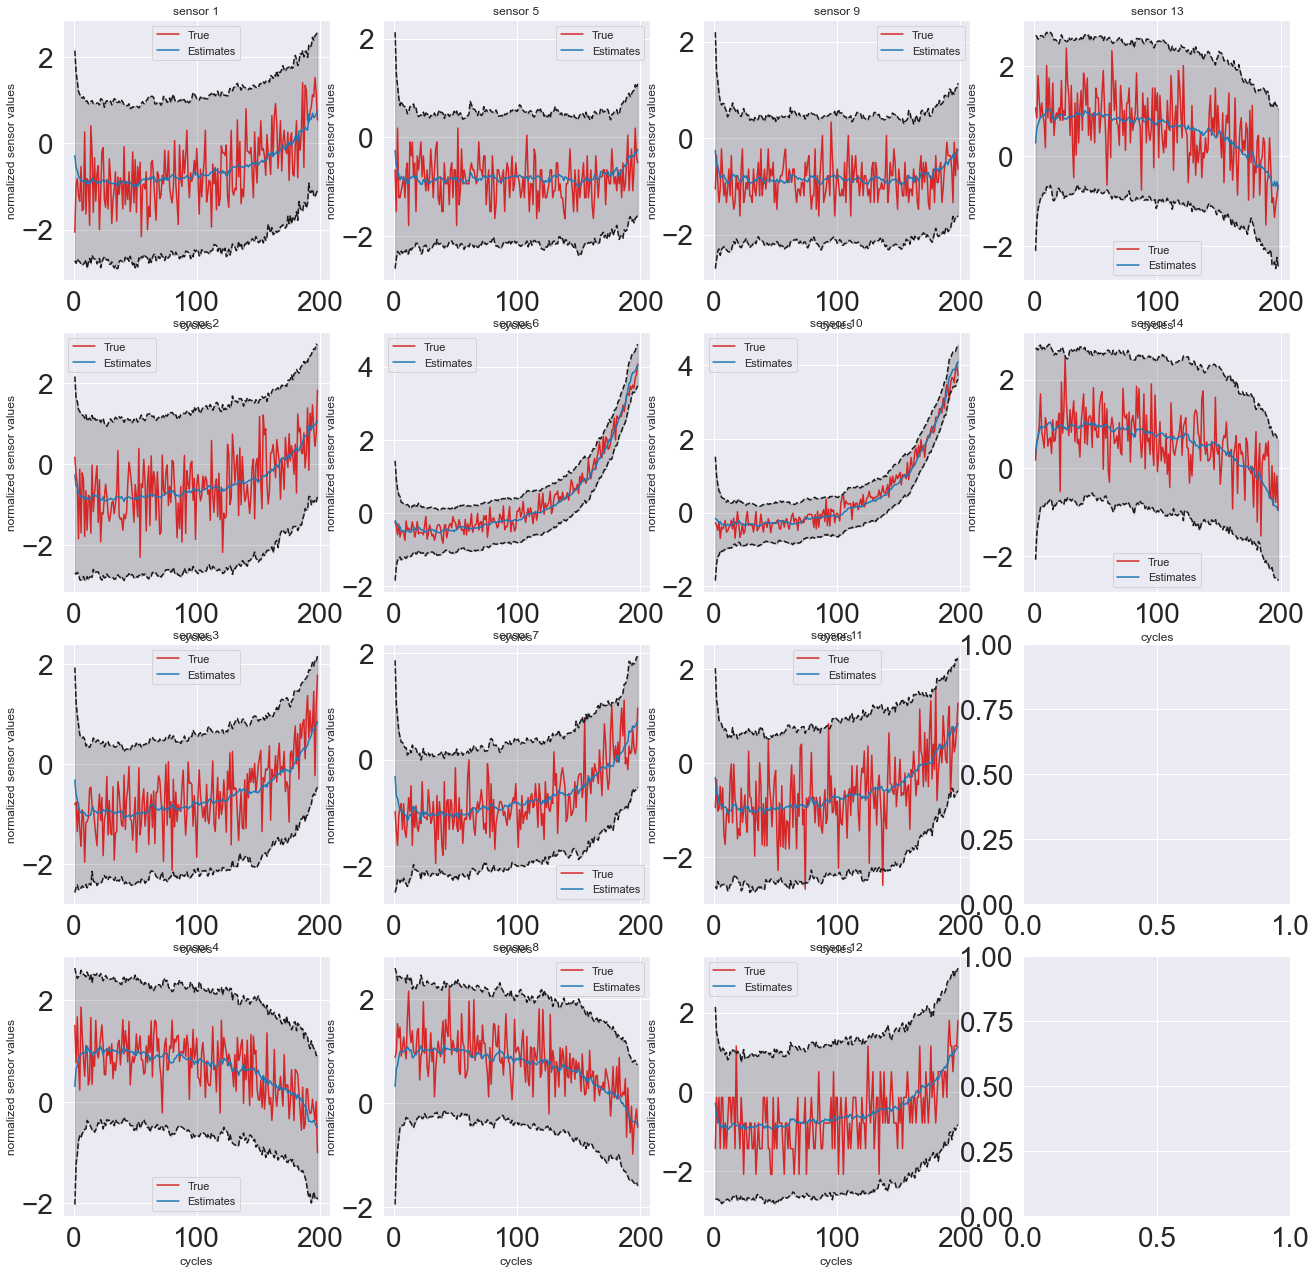

In [55]:
plot_semi_supervised_sensors(100, results)